# Tutorial 8: Restricted Boltzmann Machines

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm
import sys

## Section 1: Defining RBM class

The following is a full implementation of a class for RBMs models.

**Exercise**: The contrastive divergence method of the class contains five gaps which you need to fill.

In [2]:
BATCH_SIZE = 64
class RBM(nn.Module):
    '''
    This class defines all the functions needed for an BinaryRBN model
    where the visible and hidden units are both considered binary
    '''

    def __init__(self,
                visible_units=256,
                hidden_units = 64,
                k=2,
                learning_rate=1e-5,
                learning_rate_decay = False,
                xavier_init = False,
                increase_to_cd_k = False,
                use_gpu = False
                ):
        '''
        Defines the model
        W:Wheights shape (visible_units,hidden_units)
        c:hidden unit bias shape (hidden_units , )
        b : visible unit bias shape(visisble_units ,)
        '''
        super(RBM,self).__init__()
        self.desc = "RBM"

        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.xavier_init = xavier_init
        self.increase_to_cd_k = increase_to_cd_k
        self.use_gpu = use_gpu
        self.batch_size = 16


        # Initialization
        if not self.xavier_init:
            self.W = torch.randn(self.visible_units,self.hidden_units) * 0.01 #weights
        else:
            self.xavier_value = torch.sqrt(torch.FloatTensor([1.0 / (self.visible_units + self.hidden_units)]))
            self.W = -self.xavier_value + torch.rand(self.visible_units, self.hidden_units) * (2 * self.xavier_value)
        self.h_bias = torch.zeros(self.hidden_units) #hidden layer bias
        self.v_bias = torch.zeros(self.visible_units) #visible layer bias


    def to_hidden(self ,X):
        '''
        Converts the data in visible layer to hidden layer
        also does sampling
        X here is the visible probabilities
        :param X: torch tensor shape = (n_samples , n_features)
        :return -  X_prob - new hidden layer (probabilities)
                    sample_X_prob - Gibbs sampling of hidden (1 or 0) based
                                on the value
        '''
        X_prob = torch.matmul(X,self.W)
        X_prob = torch.add(X_prob, self.h_bias)#W.x + c
        X_prob  = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def to_visible(self,X):
        '''
        reconstructs data from hidden layer
        also does sampling
        X here is the probabilities in the hidden layer
        :returns - X_prob - the new reconstructed layers(probabilities)
                    sample_X_prob - sample of new layer(Gibbs Sampling)
        '''
        # computing hidden activations and then converting into probabilities
        X_prob = torch.matmul(X ,self.W.transpose( 0 , 1) )
        X_prob = torch.add(X_prob , self.v_bias)
        X_prob = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def sampling(self,prob):
        '''
        Bernoulli sampling done based on probabilities s
        '''
        s = torch.distributions.Bernoulli(prob).sample()
        return s

    def reconstruction_error(self , data):
        '''
        Computes the reconstruction error for the data
        handled by pytorch by loss functions
        '''
        return self.contrastive_divergence(data, False)

    def reconstruct(self , X,n_gibbs):
        '''
        This will reconstruct the sample with k steps of gibbs Sampling
        '''
        v = X
        for i in range(n_gibbs):
            prob_h_,h = self.to_hidden(v)
            prob_v_,v = self.to_visible(prob_h_)
        return prob_v_,v


    def contrastive_divergence(self, input_data ,training = True,
                                n_gibbs_sampling_steps=1,lr = 0.001):
        # positive phase

        positive_hidden_probabilities,positive_hidden_act  = # GAP 1

        # calculating W via positive side
        positive_associations = # GAP 2



        # negetive phase
        hidden_activations = positive_hidden_act
        for i in range(n_gibbs_sampling_steps):
            visible_probabilities , _ = self.to_visible(hidden_activations)
            hidden_probabilities,hidden_activations = self.to_hidden(visible_probabilities)

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        # calculating W via negative side
        negative_associations = # GAP 3


        # Update parameters
        if(training):

            batch_size = self.batch_size

            g = (positive_associations - negative_associations)
            grad_update = g / batch_size
            v_bias_update = # GAP 4
            h_bias_update = # GAP 5

            self.W += lr * grad_update
            self.v_bias += lr * v_bias_update
            self.h_bias += lr * h_bias_update


        # Compute reconstruction error
        error = torch.mean(torch.sum((input_data - negative_visible_probabilities)**2 , dim = 0))

        return error,torch.sum(torch.abs(grad_update))


    def forward(self,input_data):
        'data->hidden'
        return  self.to_hidden(input_data)
    def step(self,input_data,epoch,num_epochs):
        '''
            Includes the foward prop plus the gradient descent
            Use this for training
        '''
        if self.increase_to_cd_k:
            n_gibbs_sampling_steps = int(math.ceil((epoch/num_epochs) * self.k))
        else:
            n_gibbs_sampling_steps = self.k

        if self.learning_rate_decay:
            lr = self.learning_rate / epoch
        else:
            lr = self.learning_rate

        return self.contrastive_divergence(input_data , True,n_gibbs_sampling_steps,lr);


    def train(self,train_dataloader , num_epochs = 50,batch_size=16):

        self.batch_size = batch_size
        if(isinstance(train_dataloader ,torch.utils.data.DataLoader)):
            train_loader = train_dataloader
        else:
            train_loader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)


        for epoch in range(1 , num_epochs+1):
            epoch_err = 0.0
            n_batches = int(len(train_loader))
            # print(n_batches)

            cost_ = torch.FloatTensor(n_batches , 1)
            grad_ = torch.FloatTensor(n_batches , 1)

            for i,(batch,_) in tqdm(enumerate(train_loader),ascii=True,
                                desc="RBM fitting", file=sys.stdout):

                batch = batch.view(len(batch) , self.visible_units)
                
                if(self.use_gpu):
                    batch = batch.cuda()
                cost_[i-1],grad_[i-1] = self.step(batch,epoch,num_epochs)


            print("Epoch:{} ,avg_cost = {} ,std_cost = {} ,avg_grad = {} ,std_grad = {}".format(epoch,\
                                                            torch.mean(cost_),\
                                                            torch.std(cost_),\
                                                            torch.mean(grad_),\
                                                            torch.std(grad_)))

        return

## Section 2: Using RBM on MNIST

In [5]:
import torch 
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np

In [6]:
#Loading MNIST dataset
mnist_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

0it [00:00, ?it/s]

9920512it [00:03, 3064280.19it/s]                             


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 128221.26it/s]           
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:01, 1486594.76it/s]                             
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


8192it [00:00, 40197.50it/s]            

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [7]:
# Need to convert th data into binary variable
mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255).bernoulli()

The number shown is the number: 2


/Users/ahmad/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/ahmad/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


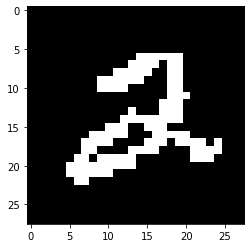

In [8]:
#Lets us visualize a number from the data set
idx = 5
img = mnist_data.train_data[idx]
print("The number shown is the number: {}".format(mnist_data.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [9]:
# If we train on the whole set we expect it to learn to detect edges.
batch_size= 10
tensor_x = mnist_data.train_data.type(torch.FloatTensor) # transform to torch tensors
tensor_y = mnist_data.train_labels.type(torch.FloatTensor)
_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
train_loader = torch.utils.data.DataLoader(_dataset,
                    batch_size=batch_size, shuffle=True,drop_last = True)

In [10]:
# I have have set these hyper parameters although you can experiment with them to find better hyperparameters.
visible_units=28*28
hidden_units = 500
k=3
learning_rate=0.01
learning_rate_decay = True
xavier_init = True
increase_to_cd_k = False
use_gpu = False


rbm_mnist = RBM(visible_units,hidden_units,k ,learning_rate,learning_rate_decay,xavier_init,
                increase_to_cd_k,use_gpu)

In [11]:
epochs = 30
rbm_mnist.train(train_loader , epochs,batch_size)

RBM fitting: 6000it [00:12, 497.55it/s]
Epoch:1 ,avg_cost = 0.5183620452880859 ,std_cost = 0.11968259513378143 ,avg_grad = 11100.32421875 ,std_grad = 1939.26953125
RBM fitting: 6000it [00:11, 532.53it/s]
Epoch:2 ,avg_cost = 0.40890368819236755 ,std_cost = 0.04119374603033066 ,avg_grad = 9936.46875 ,std_grad = 473.47320556640625
RBM fitting: 6000it [00:11, 518.39it/s]
Epoch:3 ,avg_cost = 0.38853898644447327 ,std_cost = 0.039108745753765106 ,avg_grad = 9908.1083984375 ,std_grad = 485.68450927734375
RBM fitting: 6000it [00:11, 519.23it/s]
Epoch:4 ,avg_cost = 0.3775714635848999 ,std_cost = 0.03724426031112671 ,avg_grad = 9918.705078125 ,std_grad = 493.6042175292969
RBM fitting: 6000it [00:13, 452.71it/s]
Epoch:5 ,avg_cost = 0.3705762028694153 ,std_cost = 0.036818087100982666 ,avg_grad = 9939.3564453125 ,std_grad = 493.4045104980469
RBM fitting: 6000it [00:12, 461.85it/s]
Epoch:6 ,avg_cost = 0.3652539551258087 ,std_cost = 0.03662553057074547 ,avg_grad = 9951.953125 ,std_grad = 511.666870117

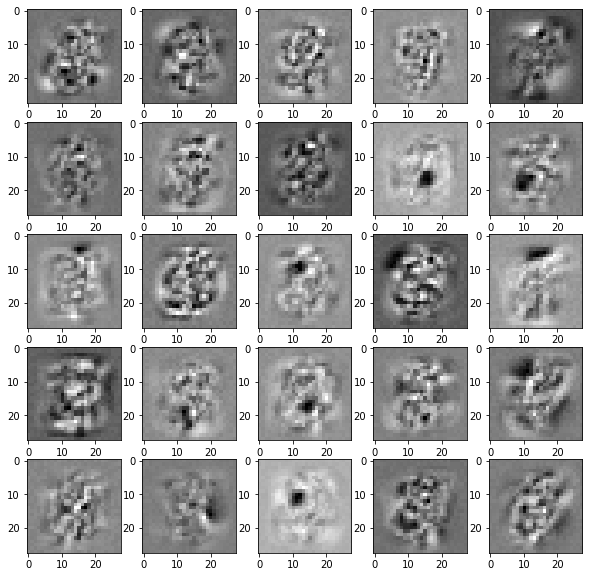

In [12]:
learned_weights = rbm_mnist.W.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25): 
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

**Exercise**: Inspect the images generated by trained network when using different learning rates and different number of hidden units. What pattern do you observe? Can you relate it to the theory covered in the lecture notes?

## Section 3: RBM on one number

This is an unsupervised learning algorithm. So let us try training on one particular number.But first we need to seperate the data.

In [17]:
number = 5 #A number between 0 and 10.
particular_mnist = []

limit = mnist_data.train_data.shape[0]
# limit = 60000
for i in range(limit):
    if(mnist_data.train_labels[i] == number):
        particular_mnist.append(mnist_data.train_data[i].numpy())
# particular_mnist = np.array(particular_mnist)
len(particular_mnist)
# mnist_data.train_data

5421

In [18]:
tensor_x = torch.stack([torch.Tensor(i) for i in particular_mnist]).type(torch.FloatTensor)
tensor_y = torch.stack([torch.Tensor(number) for i in range(len(particular_mnist))]).type(torch.FloatTensor)

In [19]:
mnist_particular_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
mnist_particular_dataloader = torch.utils.data.DataLoader(mnist_particular_dataset,batch_size = batch_size,drop_last=True,num_workers=0)

In [20]:
visible_units=28*28
hidden_units = 500
k=3
learning_rate=0.01
learning_rate_decay = False
xavier_init = True
increase_to_cd_k = False
use_gpu = False


rbm_mnist = RBM(visible_units,hidden_units,k ,learning_rate,learning_rate_decay,xavier_init,
                increase_to_cd_k,use_gpu)


epochs = 10

rbm_mnist.train(mnist_particular_dataloader , epochs)

RBM fitting: 542it [00:01, 528.36it/s]
Epoch:1 ,avg_cost = 0.7565740942955017 ,std_cost = 0.16465263068675995 ,avg_grad = 10009.1826171875 ,std_grad = 3253.0439453125
RBM fitting: 542it [00:01, 535.47it/s]
Epoch:2 ,avg_cost = 0.6140133142471313 ,std_cost = 0.057677511125802994 ,avg_grad = 7905.65576171875 ,std_grad = 438.065185546875
RBM fitting: 542it [00:01, 528.29it/s]
Epoch:3 ,avg_cost = 0.5575262904167175 ,std_cost = 0.05138789117336273 ,avg_grad = 7377.9697265625 ,std_grad = 370.08319091796875
RBM fitting: 542it [00:01, 431.43it/s]
Epoch:4 ,avg_cost = 0.5278443098068237 ,std_cost = 0.04819159209728241 ,avg_grad = 7085.4072265625 ,std_grad = 340.1481018066406
RBM fitting: 542it [00:01, 448.04it/s]
Epoch:5 ,avg_cost = 0.5071239471435547 ,std_cost = 0.04638355225324631 ,avg_grad = 6916.03564453125 ,std_grad = 330.4877014160156
RBM fitting: 542it [00:01, 456.18it/s]
Epoch:6 ,avg_cost = 0.4882071614265442 ,std_cost = 0.044589411467313766 ,avg_grad = 6770.70947265625 ,std_grad = 322.92

**Exercise**: fill the following cell to display the weigths for each of the 64 hidden neurons and thus gives us an idea on how each neuron is acitvated.

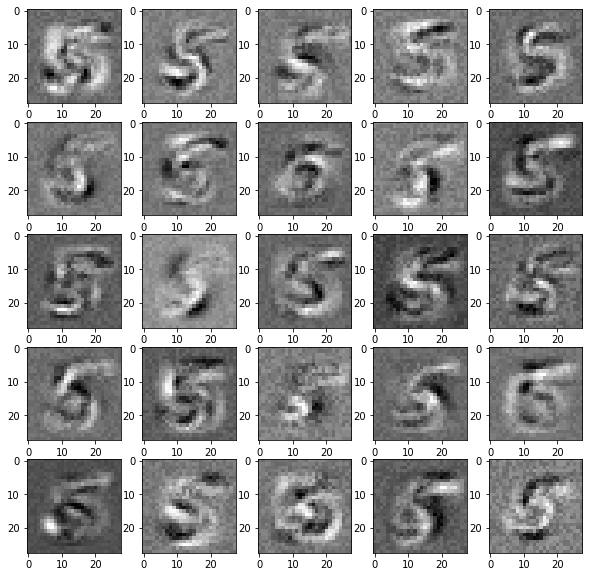

In [23]:
# Gap

The original number: 3


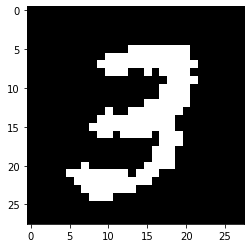

The reconstructed image


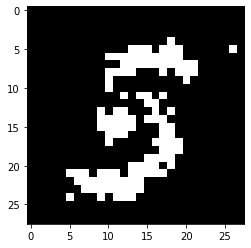

In [24]:
#Lets try reconstructing a random number from this model which has learned 5
idx = 7
img = mnist_data.train_data[idx]
reconstructed_img = img.view(-1).type(torch.FloatTensor)

# _ , reconstructed_img = rbm_mnist.to_hidden(reconstructed_img)
# _ , reconstructed_img = rbm_mnist.to_visible(reconstructed_img)

_,reconstructed_img = rbm_mnist.reconstruct(reconstructed_img,1)
# print(reconstructed_img)
reconstructed_img = reconstructed_img.view((28,28))
print("The original number: {}".format(mnist_data.train_labels[idx]))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img , cmap = 'gray')
plt.show()